<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">scRNA-Seq - Foetal Project</h1> 
    <h2 style="color:#483D8B;text-align:center;">Differential expression analysis membrane proteins</h2>
    <br>02 September 2020 @ Sanger WTSI
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Research Associate – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at860@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at19@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import numpy as np
import scipy as sp
from scipy.spatial import distance
from scipy.sparse import issparse
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import sys, os

from gprofiler import GProfiler

sys.path.append("../Functions")

from scRNA_functions import scRNA_functions

random_state = 8

np.warnings.filterwarnings('ignore')

In [2]:
fc   = scRNA_functions()

 * Initialising ...


# Functions

In [3]:
def _calculateMAGs(adata, cells=[], n_top=100, binary=False):     
    dat = adata[adata.obs.index.isin(cells)].copy()
    dat = sc.pp.normalize_per_cell(dat, counts_per_cell_after=100, copy=True)
    if issparse(dat.X):
        dat.var['mean_percent'] = dat.X.mean(axis=0).A1
    else:
        dat.var['mean_percent'] = dat.X.mean(axis=0)
    top = dat.var.sort_values('mean_percent', ascending=False).index[:n_top]
    dat = dat[:, top]
    columns = dat.var_names
    data = dat.X.toarray()
    if binary:
        data = (data > 0).astype(int)
    dat = pd.DataFrame(data, index=dat.obs_names, columns=columns)
    return dat.T

def plotTwoGroupsGenes(adata,
                       group_by  = None,
                       variable1 = None,
                       variable2 = None,
                       use_raw   = False,
                       maplot    = True,
                       jaccard   = True,
                       topGenes  = 50,
                       logfc_th  = 1.0,
                       figsize   = (12, 9)):
        
    if group_by not in adata.obs.columns.tolist():
        print("Provide a valid variable to group the data")
        return
    
    if variable1 is None or variable2 is None:
        if variable1 is None:
            print("Provide a valid value for variable1")
        if variable2 is None:
            print("Provide a valid value for variable2")
        return
    
    group1_cells = adata[adata.obs[group_by]==variable1]
    group2_cells = adata[adata.obs[group_by]==variable2]
    
    if use_raw:
        group1_data  = pd.DataFrame(data    = group1_cells.raw.X,
                                    index   = group1_cells.obs.index,
                                    columns = group1_cells.var.index)
        
        group2_data  = pd.DataFrame(data    = group2_cells.raw.X,
                                    index   = group2_cells.obs.index,
                                    columns = group2_cells.var.index)
    else:
        group1_data  = pd.DataFrame(data    = group1_cells.X,
                                    index   = group1_cells.obs.index,
                                    columns = group1_cells.var.index)
        
        group2_data  = pd.DataFrame(data    = group2_cells.X,
                                    index   = group2_cells.obs.index,
                                    columns = group2_cells.var.index)
        
        
    df = pd.DataFrame(index=adata.var.index)

    n_cells1 = (group1_data>0).astype(int).sum()
    n_cells2 = (group2_data>0).astype(int).sum()

    df[variable1] = group1_data.sum()/n_cells1
    df[variable2] = group2_data.sum()/n_cells2

    if maplot:
        sns.set_style("whitegrid")
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        sns.set(font_scale=1.5)

        M = np.log2(df[variable1].fillna(0)) - np.log2(df[variable2].fillna(0))
        A = 0.5*(np.log2(df[variable1].fillna(0)) + np.log2(df[variable2].fillna(0)))

        MA = pd.DataFrame(index=adata.var.index)
        MA["log2FC"] = M


        MA.loc[(MA["log2FC"] >= logfc_th), 'color']  = "green" # upregulated
        MA.loc[(MA["log2FC"] <= -logfc_th), 'color'] = "red"  # downregulated
        MA['color'].fillna('#A9A9A9', inplace=True)  # intermediate
        MA['log2ME'] = A
        # plot
        plt.scatter(MA['log2ME'], MA["log2FC"], c=MA['color'], s=figsize[0]*8)
        # draw a central line at M=0
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('log2 fold change',    fontsize=15, fontname="sans-serif", fontweight="bold")
        plt.ylabel('log2 mean expression', fontsize=15, fontname="sans-serif", fontweight="bold")
        plt.xticks(fontsize=12, fontname="sans-serif")
        plt.yticks(fontsize=12, fontname="sans-serif")

        limit = MA["log2FC"].replace(-np.inf, np.nan)
        limit = limit.replace(np.inf, np.nan)
        limit = limit.fillna(0)
        limit = max(abs(limit))

        plt.ylim(-limit-limit*0.1, limit+0.1*limit)

        custom_lines = [Line2D([0], [0], marker='o', color='green', label='Scatter',
                               markerfacecolor='green', markersize=15, linestyle=''),
                        Line2D([0], [0], marker='o', color='red', label='Scatter',
                               markerfacecolor='red', markersize=15, linestyle='')]

        plt.legend(custom_lines, ['upregulated', 'downregulated'], frameon=False)

        sns.despine(offset=10, trim=False)
        plt.show(block=False)


    dictionary = {}

    dictionary[variable1] = group1_data
    dictionary[variable2] = group2_data
    dictionary[variable1+"-n_cells"] = n_cells1
    dictionary[variable2+"-n_cells"] = n_cells2
    dictionary[variable1+"-norm"] = df[variable1]
    dictionary[variable2+"-norm"] = df[variable2]

    if topGenes > 0:


        group1_index = dictionary[variable1+"-norm"][dictionary[variable1+"-norm"]>0].index.tolist()
        group2_index = dictionary[variable2+"-norm"][dictionary[variable2+"-norm"]>0].index.tolist()
        intersection = list(set(group1_index).intersection(set(group2_index)))

        print()
        print("Top expressed genes in %s"%variable1)
        difference_group1 = list(set(dictionary[variable1+"-norm"].index.tolist()).difference(set(intersection)))
        group1            = dictionary[variable1+"-norm"][dictionary[variable1+"-norm"].index.isin(difference_group1)]
        group1_ncells     = dictionary[variable1+"-n_cells"][dictionary[variable1+"-n_cells"].index.isin(difference_group1)]

        topNgenes = group1[group1>0].sort_values(ascending=False)[0:topGenes]
        cells     = group1_ncells[group1_ncells.index.isin(topNgenes.index)]

        topNgenes.sort_index(inplace=True)
        cells.sort_index(inplace=True)

        df = pd.DataFrame(index = topNgenes.index,
                          columns=["top %d genes"%topGenes, "n cells"],
                          data=np.array([topNgenes.values, cells.values]).T)
        del df.index.name
        df.sort_values(by=["top %d genes"%topGenes], ascending=False, inplace=True)
        df["n cells"] = df["n cells"].astype(int)
        display(df)

        print()
        print("Top expressed genes in %s"%variable2)
        difference_group2 = list(set(dictionary[variable2+"-norm"].index.tolist()).difference(set(intersection)))
        group2            = dictionary[variable2+"-norm"][dictionary[variable2+"-norm"].index.isin(difference_group2)]
        group2_ncells     = dictionary[variable2+"-n_cells"][dictionary[variable2+"-n_cells"].index.isin(difference_group2)]

        topNgenes = group2[group2>0].sort_values(ascending=False)[0:topGenes]
        cells     = group2_ncells[group2_ncells.index.isin(topNgenes.index)]

        topNgenes.sort_index(inplace=True)
        cells.sort_index(inplace=True)

        df = pd.DataFrame(index = topNgenes.index,
                          columns=["top %d genes"%topGenes, "n cells"],
                          data=np.array([topNgenes.values, cells.values]).T)
        del df.index.name
        df.sort_values(by=["top %d genes"%topGenes], ascending=False, inplace=True)
        df["n cells"] = df["n cells"].astype(int)
        display(df)

    if jaccard:
        sns.set_style("whitegrid")
        fig, ax = plt.subplots(1,1, figsize=(100,100))
        sns.set(font_scale=1.8)

        data = (adata.X > 0).astype(int)
        dat  = pd.DataFrame(data, index=adata.obs_names, columns=adata.var_names).T

        d_jac = np.zeros((adata.n_obs, adata.n_obs))
        for i, cell1 in enumerate(adata.obs_names):
            for j, cell2 in enumerate(adata.obs_names):
                if i>j:
                    jac = distance.jaccard(dat[cell1].tolist(), dat[cell2].tolist())
                    d_jac[i,j] = 1 - jac
        d_jac = pd.DataFrame(d_jac, index=dat.columns, columns=dat.columns)
        mask = np.zeros_like(d_jac)
        mask[np.triu_indices_from(mask)] = True

        with sns.axes_style("white"):
            sns.heatmap(d_jac, linewidths=.5, mask=mask, vmin=0, vmax=1, cmap=cm.seismic, ax=ax, cbar=True, annot=False)
        ax.set_title('Jaccard among all genes and cells', fontsize=60)
        plt.show(block=False)


        fig, ax = plt.subplots(1,1, figsize=(100,100))
        sns.set(font_scale=1.8)

        dat = _calculateMAGs(adata, cells=adata.obs_names, n_top=topGenes, binary=True)
        d_jac = np.zeros((len(adata.obs_names), len(adata.obs_names)))
        for i, cell1 in enumerate(adata.obs_names):
            for j, cell2 in enumerate(adata.obs_names):
                if i>j:
                    jac = distance.jaccard(dat[cell1].tolist(), dat[cell2].tolist())
                    d_jac[i,j] = 1 - jac
        d_jac = pd.DataFrame(d_jac, index=dat.columns, columns=dat.columns)
        mask = np.zeros_like(d_jac)
        mask[np.triu_indices_from(mask)] = True

        with sns.axes_style("white"):
            sns.heatmap(d_jac, linewidths=.5, mask=mask, vmin=0, vmax=1, cmap=cm.seismic, ax=ax, cbar=True, annot=False)
        ax.set_title('Jaccard among Top %d MAGs'%topGenes, fontsize=60)
        plt.show(block=False)

    return dictionary

In [4]:
gp = GProfiler(return_dataframe=True)

def GOTermAnalysis(df, pval_th=0.01, difference="High", show=True, plot=True):
    
    pd.set_option('display.max_rows', df.shape[0]+1)

    groups = np.unique(df["group"])

    for group in groups:
        
        if group == "Group":
            continue

        print("* GO term analysis on group %s"%group)

        if difference == "All":
            print("\tUsing all genes")
            genes = df[df["group"]==group].index.tolist()
            if show:
                display(df[df.index.isin(genes)])

        else:
            print("\tUsing only gene with %s difference"%difference)
            df1   = df[df["difference"]==difference]
            genes = df1[df1["group"]==group].index.tolist()
            if show:
                display(df1[df1.index.isin(genes)])
        
        if len(genes) > 0:
            
            res = gp.profile(genes,
                             organism                      = "hsapiens",
                             sources                       = ['GO:BP', "GO:CC", "GO:MF"],
                             user_threshold                = pval_th,
                             all_results                   = False,
                             ordered                       = False,
                             no_evidences                  = True,
                             combined                      = False,
                             measure_underrepresentation   = False,
                             no_iea                        = False,
                             domain_scope                  = 'annotated',
                             numeric_namespace             = '',
                             significance_threshold_method = "fdr",
                             background                    = None
                            )
            
            if res is not None:
                if res.shape[0] > 0 and plot:

                    res["-log10(p-val)"] = -np.log10(res["p_value"])
                    res = res.sort_values(by=["-log10(p-val)"], ascending=False)

                    sns.set(font_scale=1.1)
                    sns.set_style("whitegrid")
                    ax = sns.catplot(x="-log10(p-val)", y="name", col="source", data=res, kind="bar", hue="source", height=12)
                    plt.tight_layout()
                    plt.show(block=False)
                    
        print("\n\n")

In [5]:
def __runDE(adata,
            group_by,
            group1,
            group2,
            use_raw,
            log,
            min_pct,
            max_pct,
            min_fc,
            where):
    
    
    sc.tl.rank_genes_groups(adata,
                            groupby     = group_by,
                            use_raw     = use_raw,
                            reference   = group1,
                            groups      = [group2],
                            n_genes     = adata.n_vars,
                            key_added   = "%sVS%s"%(group1, group2),
                            method      = 'wilcoxon',
                            corr_method = 'benjamini-hochberg')


    sc.tl.rank_genes_groups(adata,
                            groupby     = group_by,
                            use_raw     = use_raw,
                            reference   = group2,
                            groups      = [group1],
                            n_genes     = adata.n_vars,
                            key_added   = "%sVS%s"%(group2, group1),
                            method      = 'wilcoxon',
                            corr_method = 'benjamini-hochberg')

    sc.tl.filter_rank_genes_groups(adata,
                                   key                    = "%sVS%s"%(group1, group2),
                                   groupby                = group_by,
                                   key_added              = "%sVS%s_filtered"%(group1, group2),
                                   use_raw                = use_raw,
                                   log                    = log,
                                   min_in_group_fraction  = min_pct,
                                   max_out_group_fraction = max_pct,
                                   min_fold_change        = min_fc)


    sc.tl.filter_rank_genes_groups(adata,
                                   key                    = "%sVS%s"%(group2, group1),
                                   groupby                = group_by,
                                   key_added              = "%sVS%s_filtered"%(group2, group1),
                                   use_raw                = use_raw,
                                   log                    = log,
                                   min_in_group_fraction  = min_pct,
                                   max_out_group_fraction = max_pct,
                                   min_fold_change        = min_fc)
    
    
    keys = ["gene", "log2fc", "pval", "pval_adj"]

    result1 = adata.uns["%sVS%s_filtered"%(group1, group2)]
    groups1 = result1['names'].dtype.names
    df1     = pd.DataFrame({keys[idx]: result1[key][group]
                            for group in groups1 for idx,key in enumerate(['names',
                                                                           'logfoldchanges',
                                                                           'pvals',
                                                                           'pvals_adj'])})


    result2 = adata.uns["%sVS%s_filtered"%(group2, group1)]
    groups2 = result2['names'].dtype.names
    df2     = pd.DataFrame({keys[idx]: result2[key][group]
                            for group in groups2 for idx,key in enumerate(['names',
                                                                           'logfoldchanges',
                                                                           'pvals',
                                                                           'pvals_adj'])})


    df1 = df1.dropna()
    df2 = df2.dropna()

    if where == "both":
        both   = list(set(df1["gene"]).intersection(df2["gene"]))

        df = df1[df1["gene"].isin(both)]

    if where == "either":    
        either = list(set(df1["gene"]).union(df2["gene"]))

        genes1 = list(set(either).intersection(set(df1["gene"])))
        genes2 = list(set(either).difference(set(df1["gene"])))

        genes    = df1[df1["gene"].isin(genes1)]["gene"].tolist()     + df2[df2["gene"].isin(genes2)]["gene"].tolist()
        log2fc   = df1[df1["gene"].isin(genes1)]["log2fc"].tolist()   + (-df2[df2["gene"].isin(genes2)]["log2fc"]).tolist()
        pval     = df1[df1["gene"].isin(genes1)]["pval"].tolist()     + df2[df2["gene"].isin(genes2)]["pval"].tolist()
        pval_adj = df1[df1["gene"].isin(genes1)]["pval_adj"].tolist() + df2[df2["gene"].isin(genes2)]["pval_adj"].tolist()

        df = pd.DataFrame(columns = ["gene", "log2fc", "pval", "pval_adj"])    
        df["gene"]     = genes
        df["log2fc"]   = log2fc
        df["pval"]     = pval
        df["pval_adj"] = pval_adj
    
    return df


def runDE_analysis(adata,
                   group_by  = None,
                   group1    = None,
                   group2    = None,
                   use_raw   = True,
                   log       = True,
                   plotGenes = True,
                   topGenes  = 50,
                   showDf    = False,
                   min_pct   = 0.1,
                   max_pct   = 1.0,
                   min_fc    = 0.0,
                   where     = "both",
                   logfc_th  = 1.0,
                   pval_th   = 1e-6,
                   figsize   = (12,12)):
    
    sns.set_style("white")
    
    if group_by not in adata.obs.columns.tolist():
        print("Provide a valid variable to group the data")
        return
    
    if group1 is None or group2 is None:
        if group1 is None:
            print("Provide a valid value for group1")
        if group2 is None:
            print("Provide a valid value for group2")
        return
    
    where = where.lower()
    if where not in ["both", "either"]:
        print("'where' must be equal to 'both' or 'either'")
        return
    
    
    df = __runDE(adata, group_by, group1, group2, use_raw, log, min_pct, max_pct, min_fc, where)

    df["-log10(p-val adj)"] = -np.log10(df["pval_adj"])

    df = df.dropna()
    df = df.sort_values(by=["log2fc"], ascending=False)
    
    if showDf:
        display(df)
    
    df['color']  = "0"
    df['marker'] = "0"
    df['color'].fillna('0',  inplace=True) # intermediate
    df['marker'].fillna("No Sig.", inplace=True) # intermediate
    
    # ************************************************* Both log2fc and p-val *************************************************
#     indeces = df[df['log2fc'] >= 1].nlargest(topGenes, "log2fc").index
    indeces = df[(np.abs(df['log2fc']) >= logfc_th) & (df['-log10(p-val adj)'] >= -np.log10(pval_th))].index
    genes = df['color'][indeces]
    df['color'].replace(genes, "3", inplace=True)
    
    # ************************************************* Only log2fc *************************************************
    indeces = df[(np.abs(df['log2fc']) >= logfc_th) & (df['-log10(p-val adj)'] < -np.log10(pval_th))].index
    genes = df['color'][indeces]
    df['color'].replace(genes, "2", inplace=True)
    
    # ************************************************* Only p-val *************************************************
    indeces = df[(np.abs(df['log2fc']) <= logfc_th) & (df['-log10(p-val adj)'] >= -np.log10(pval_th))].index
    genes = df['color'][indeces]
    df['color'].replace(genes, "1", inplace=True)
    
    
    # ************************************************* Marker group1 *************************************************
    indeces = df[df['log2fc'] >= logfc_th].index
    genes = df['marker'][indeces]
    df['marker'].replace(genes, "2", inplace=True)
    
    # ************************************************* Marker group2 *************************************************
    indeces = df[df['log2fc'] <= -logfc_th].index
    genes = df['marker'][indeces]
    df['marker'].replace(genes, "1", inplace=True)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.set(font_scale=1.5)
    
    colors  = ["#A9A9A9", "#722F37", "#0099ff", "#6A5ACD"]
    labels  = ["No Sig.", "p-val", "$log_2$FC", "$log_2$FC & p-val"]
    
    colors1  = []
    labels1  = ["Significance"]
    
    for c in np.unique(df['color']):
        colors1.append(colors[int(c)])
        labels1.append(labels[int(c)])
    
    labels1  += ["Group"]
    for m in np.unique(df['marker']):
        if int(m) == 0:
            labels1.append("Both")
        elif int(m) == 1:
            labels1.append(group1)
        elif int(m) == 2:
            labels1.append(group2)
            
        
    
    g = sns.scatterplot(x="log2fc",
                        y="-log10(p-val adj)",
                        hue="color",
                        style="marker",
                        palette=colors1,
                        data=df,
                        alpha=1,
                        s=figsize[0]*10,
                        ax=ax,
                        legend="full",
                        markers=["o", "X", '^'])
    
    if plotGenes:
        listTopGenes = df[(np.abs(df['log2fc']) >= logfc_th) &
                          (df['-log10(p-val adj)'] >= -np.log10(pval_th))].index.tolist()

        listTopGenes = [df[df.index.isin(listTopGenes)]["log2fc"].tolist(),
                        df[df.index.isin(listTopGenes)]["-log10(p-val adj)"].tolist(),
                        df[df.index.isin(listTopGenes)]["gene"].tolist()]
                        
        if topGenes < 0 or isinstance(topGenes, int) == False:
            for i in range(0, len(listTopGenes[0])):
                plt.text(listTopGenes[0][i],
                         listTopGenes[1][i],
                         listTopGenes[2][i],
                         fontsize=12,
                         fontname="sans-serif")
        else:

            listTopGenes = pd.DataFrame(index   = listTopGenes[:][-1],
                                columns = ["log2fc", "-log10(p-val adj)"],
                                data    = np.array(listTopGenes[:][0:2]).T)

            left   = listTopGenes[listTopGenes["log2fc"]<0]
            right  = listTopGenes[listTopGenes["log2fc"]>=0]

            left  = left.sort_values(by=['log2fc', '-log10(p-val adj)'],
                                     ascending=[True, False])

            right = right.sort_values(by=['log2fc', '-log10(p-val adj)'],
                                      ascending=[False, False])

            left   = left[left["log2fc"]<0][:topGenes].index.tolist()
            right  = right[right["log2fc"]>=0][:topGenes].index.tolist()
            
            toShow = left + right

            listTopGenes = listTopGenes[listTopGenes.index.isin(toShow)]

            for idx,gene in enumerate(listTopGenes.index):

                plt.text(listTopGenes["log2fc"][idx],
                         listTopGenes["-log10(p-val adj)"][idx],
                         gene,
                         fontsize=12,
                         fontname="sans-serif")

        
        
    plt.axhline(y=-np.log10(pval_th), linestyle="--", color="k")
    plt.axvline(x=logfc_th, linestyle="--", color="k")
    plt.axvline(x=-logfc_th, linestyle="--", color="k")

    plt.xlabel('log2FC',fontsize=15, fontname="sans-serif", fontweight="bold")
    plt.ylabel('-log10(p-val adj)', fontsize=15, fontname="sans-serif", fontweight="bold")
    plt.xticks(fontsize=12, fontname="sans-serif")
    plt.yticks(fontsize=12, fontname="sans-serif")
    
    for t, l in zip(g.legend_.texts, labels1):
        t.set_text(l)
    
    g.legend_.set_frame_on(False)
    g.legend_.set_bbox_to_anchor((1.25, 1))
                        
    ax.add_artist(g.legend_)
    
    sns.despine(offset=10, trim=False)
    plt.tight_layout()
#     plt.show(block="False")
    
    df["difference"] = "No"

    df["difference"][df["color"] == '3'] = "High"
    df["difference"][df["color"] == '2'] = "Medium"

    df["group"]      = "Group"
    df["group"][df["marker"] == '1'] = group1
    df["group"][df["marker"] == '2'] = group2

#     df = df[(df["difference"] == "High") | (df["difference"] == "Medium")]

    genes = df["gene"].tolist()
    
    g1 = adata[adata.obs[group_by]==group1]
    g2 = adata[adata.obs[group_by]==group2]
    
    if use_raw:
        expG1 = g1.raw.X[:, g1.raw.var.index.isin(genes)]
        expG2 = g2.raw.X[:, g2.raw.var.index.isin(genes)]
    else:
        expG1 = g1.X[:, g1.var.index.isin(genes)]
        expG2 = g2.X[:, g2.var.index.isin(genes)]
        
    expG1 = 100*np.sum(expG1>0, axis=0)/g1.n_obs
    expG2 = 100*np.sum(expG2>0, axis=0)/g2.n_obs
    
    df["% cells group 1"] = expG1
    df["% cells group 2"] = expG2

    df.set_index(["gene"], inplace=True)
    del df.index.name
    return df[["log2fc", "-log10(p-val adj)", "difference", "group", "% cells group 1", "% cells group 2"]], fig

# Loading data

In [6]:
adata = sc.read_h5ad('../Data/ScanpyObjets/MergedAllSamples_membrane.h5ad')

# HSC-MPPs: Liver vs Femur

In [7]:
group1 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/ShortGroup_HSC-MPPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/Subsampled_HSC-MPPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

reduced = adata[adata.obs.index.isin(group1+group2)]

np.unique(reduced.obs["Cluster"])

array(['HSC-MPPs'], dtype=object)

## Subsampling biggest cluster, genes in at least 30% of cells (both groups)

Trying to set attribute `.uns` of view, copying.


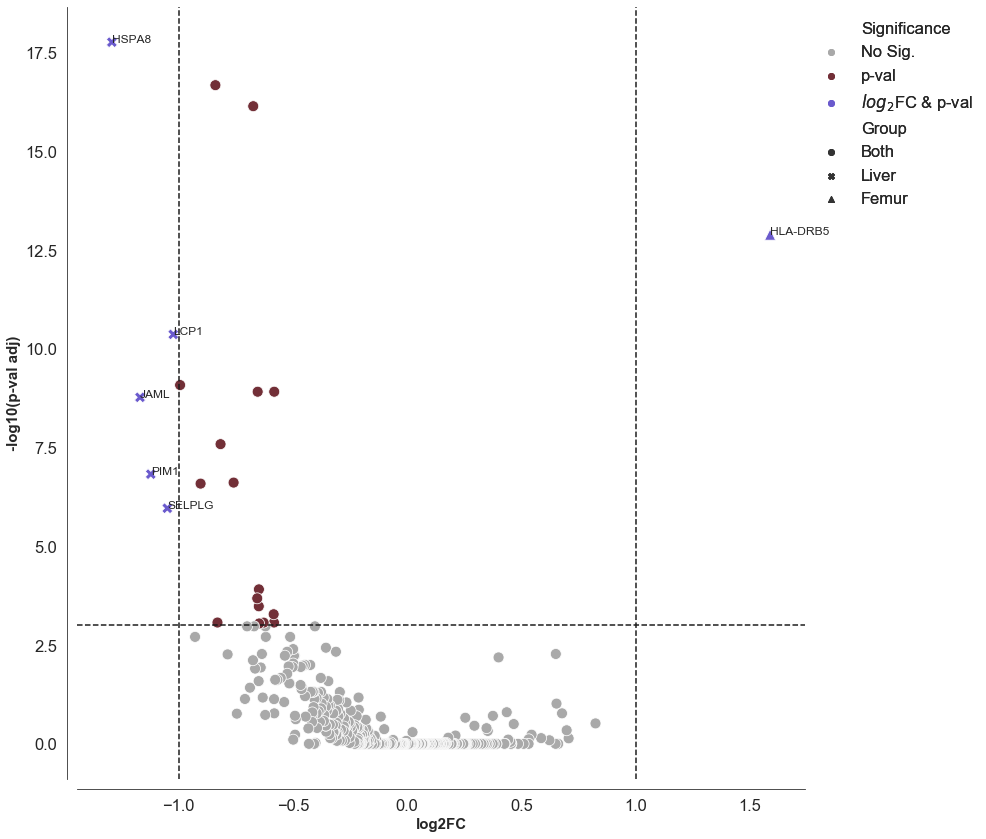

In [8]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "both",
                                logfc_th = 1,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

* GO term analysis on group Femur
	Using only gene with High difference


log2fc  -log10(p-val adj) difference  group  % cells group 1  \
HLA-DRB5  1.587982          12.893306       High  Femur        40.682415   

          % cells group 2  
HLA-DRB5        30.708661

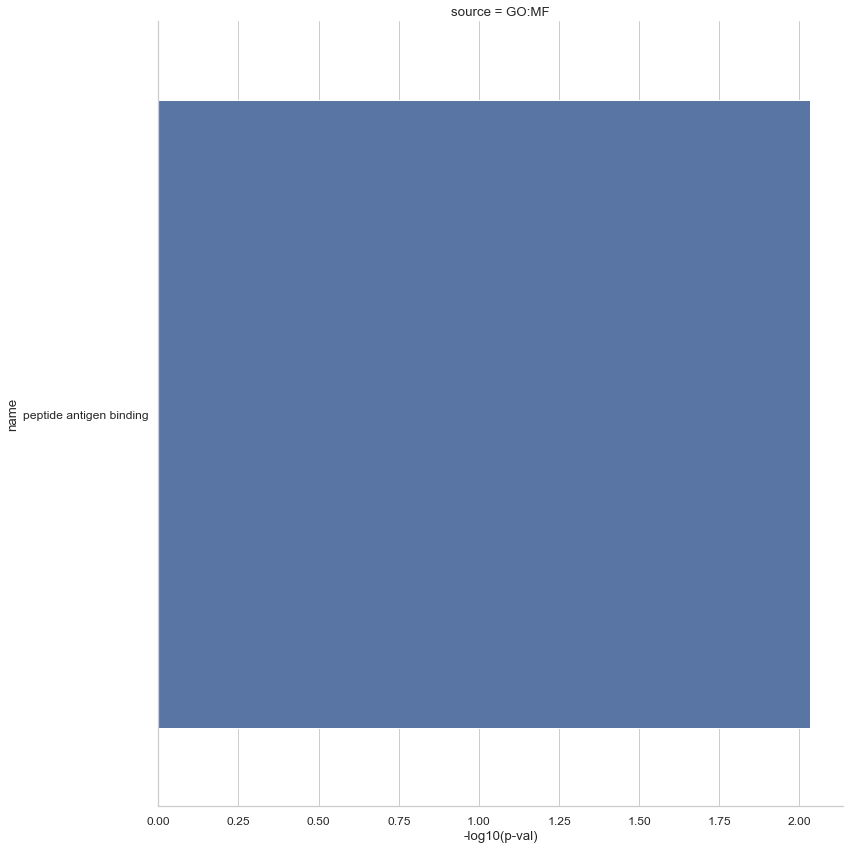




* GO term analysis on group Liver
	Using only gene with High difference


log2fc  -log10(p-val adj) difference  group  % cells group 1  \
LCP1   -1.023322          10.368517       High  Liver        93.438320   
SELPLG -1.049399           5.965443       High  Liver        58.792651   
PIM1   -1.121631           6.829222       High  Liver        70.866142   
JAML   -1.168779           8.775038       High  Liver        67.979003   
HSPA8  -1.291889          17.769161       High  Liver        33.858268   

        % cells group 2  
LCP1          93.700787  
SELPLG        46.194226  
PIM1          56.955381  
JAML          61.679790  
HSPA8         30.183727

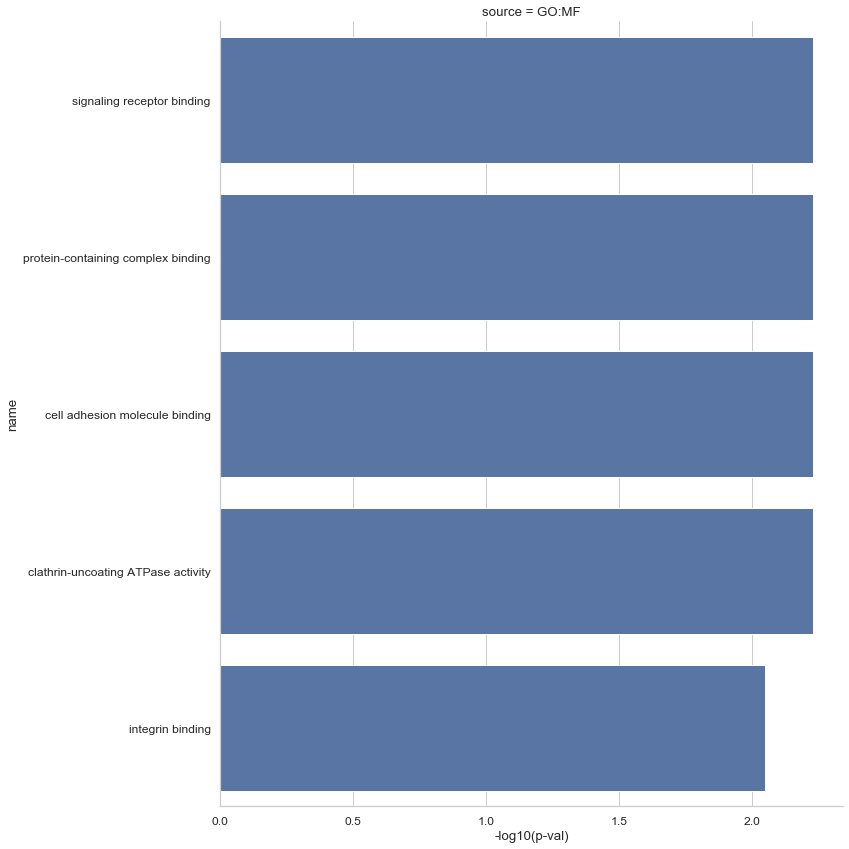

In [9]:
GOTermAnalysis(dataframe, difference="High")

## Subsampling biggest cluster, genes in at least 30% of cells (either group1 or group2)

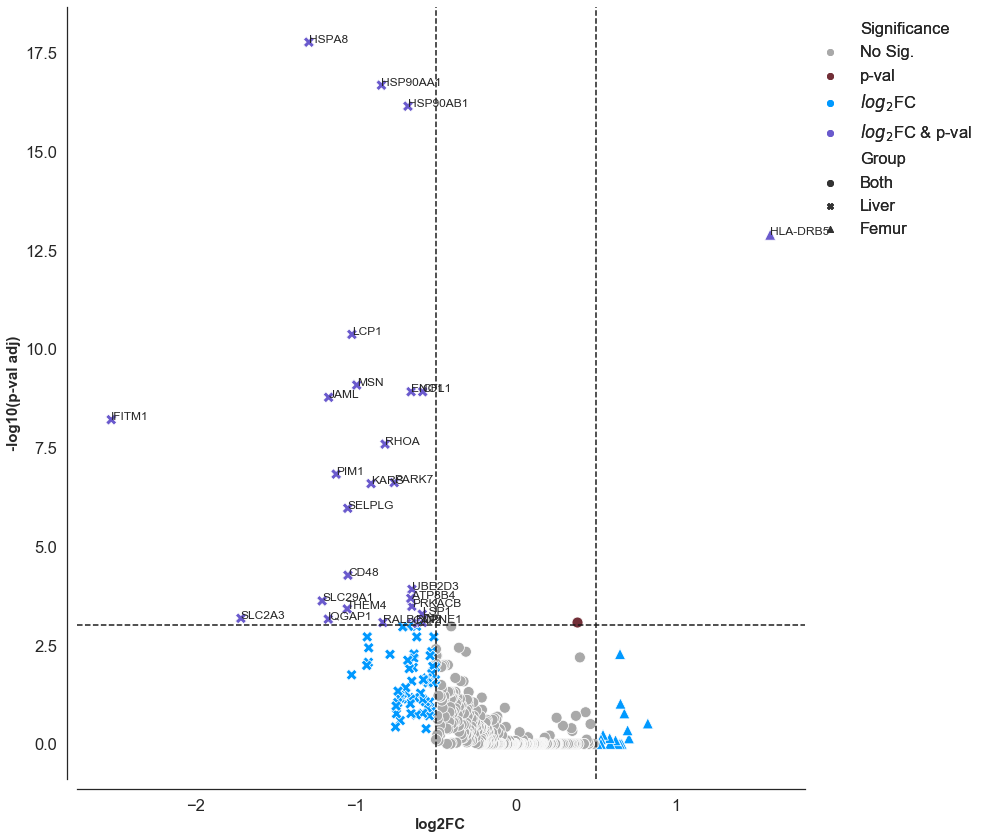

In [10]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

* GO term analysis on group Femur
	Using only gene with High difference


log2fc  -log10(p-val adj) difference  group  % cells group 1  \
HLA-DRB5  1.587982          12.893306       High  Femur        40.682415   

          % cells group 2  
HLA-DRB5        30.708661

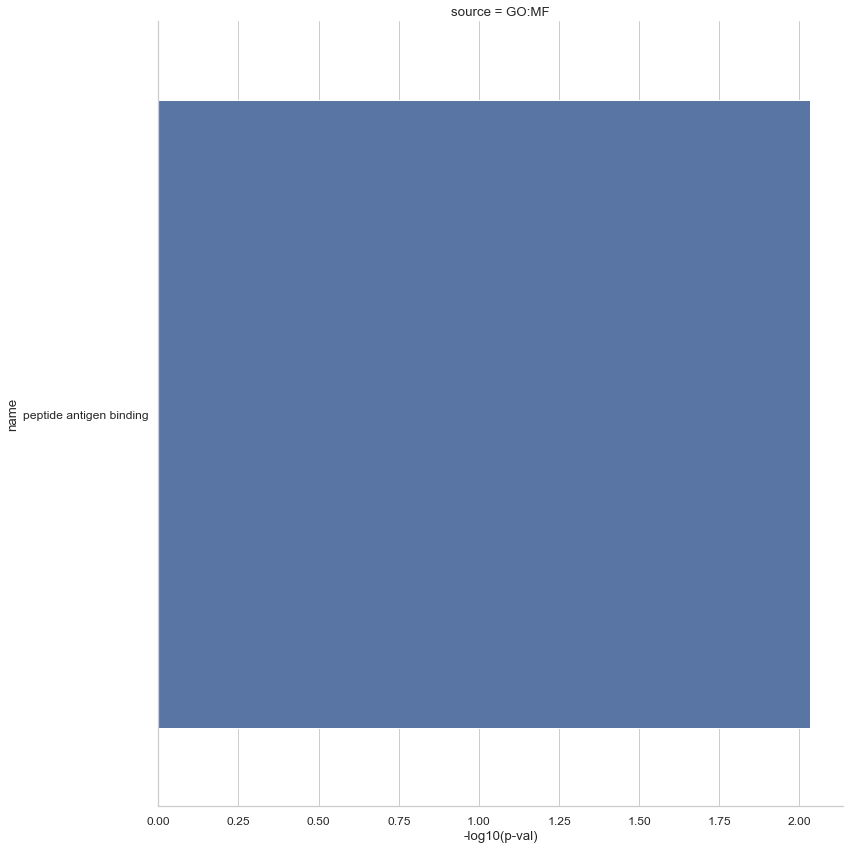




* GO term analysis on group Liver
	Using only gene with High difference


log2fc  -log10(p-val adj) difference  group  % cells group 1  \
CFL1     -0.581491           8.916708       High  Liver        62.467192   
CPNE1    -0.582713           3.071638       High  Liver        51.968504   
LSP1     -0.584016           3.281449       High  Liver        33.595801   
BIN2     -0.627897           3.069018       High  Liver        59.580052   
CAP1     -0.647617           3.047572       High  Liver        59.580052   
UBE2D3   -0.648573           3.911847       High  Liver        84.251969   
PRKACB   -0.649122           3.482660       High  Liver        59.580052   
ENO1     -0.653993           8.916708       High  Liver        38.845144   
ATP8B4   -0.655873           3.684754       High  Liver        49.606299   
HSP90AB1 -0.673396          16.147442       High  Liver        98.950131   
PARK7    -0.759285           6.615446       High  Liver        71.128609   
RHOA     -0.816442           7.588834       High  Liver        34.120735   
RALB     -0.829850           3.071638       High  Liver        97.637795   
HSP90AA1 -0.838992          16.680033       High  Liver        91.601050   
KARS     -0.903782           6.589269       High  Liver        95.538058   
MSN      -0.993394           9.085702       High  Liver        39.895013   
LCP1     -1.023322          10.368517       High  Liver        38.582677   
CD48     -1.048084           4.269636       High  Liver        96.587927   
SELPLG   -1.049399           5.965443       High  Liver        87.926509   
THEM4    -1.052908           3.416761       High  Liver        61.679790   
PIM1     -1.121631           6.829222       High  Liver        93.438320   
JAML     -1.168779           8.775038       High  Liver        35.958005   
IQGAP1   -1.171013           3.157101       High  Liver        58.792651   
SLC29A1  -1.209276           3.619579       High  Liver        70.866142   
HSPA8    -1.291889          17.769161       High  Liver        67.979003   
SLC2A3   -1.716338           3.178465       High  Liver        30.708661   
IFITM1   -2.525999           8.208855       High  Liver        33.858268   

          % cells group 2  
CFL1            50.131234  
CPNE1           50.393701  
LSP1            21.784777  
BIN2            45.406824  
CAP1            48.556430  
UBE2D3          78.740157  
PRKACB          49.868766  
ENO1            34.908136  
ATP8B4          36.482940  
HSP90AB1        98.162730  
PARK7           63.254593  
RHOA            30.708661  
RALB            97.900262  
HSP90AA1        90.026247  
KARS            92.125984  
MSN             28.083990  
LCP1            28.083990  
CD48            94.750656  
SELPLG          73.490814  
THEM4           53.543307  
PIM1            93.700787  
JAML            22.572178  
IQGAP1          46.194226  
SLC29A1         56.955381  
HSPA8           61.679790  
SLC2A3          21.522310  
IFITM1          30.183727

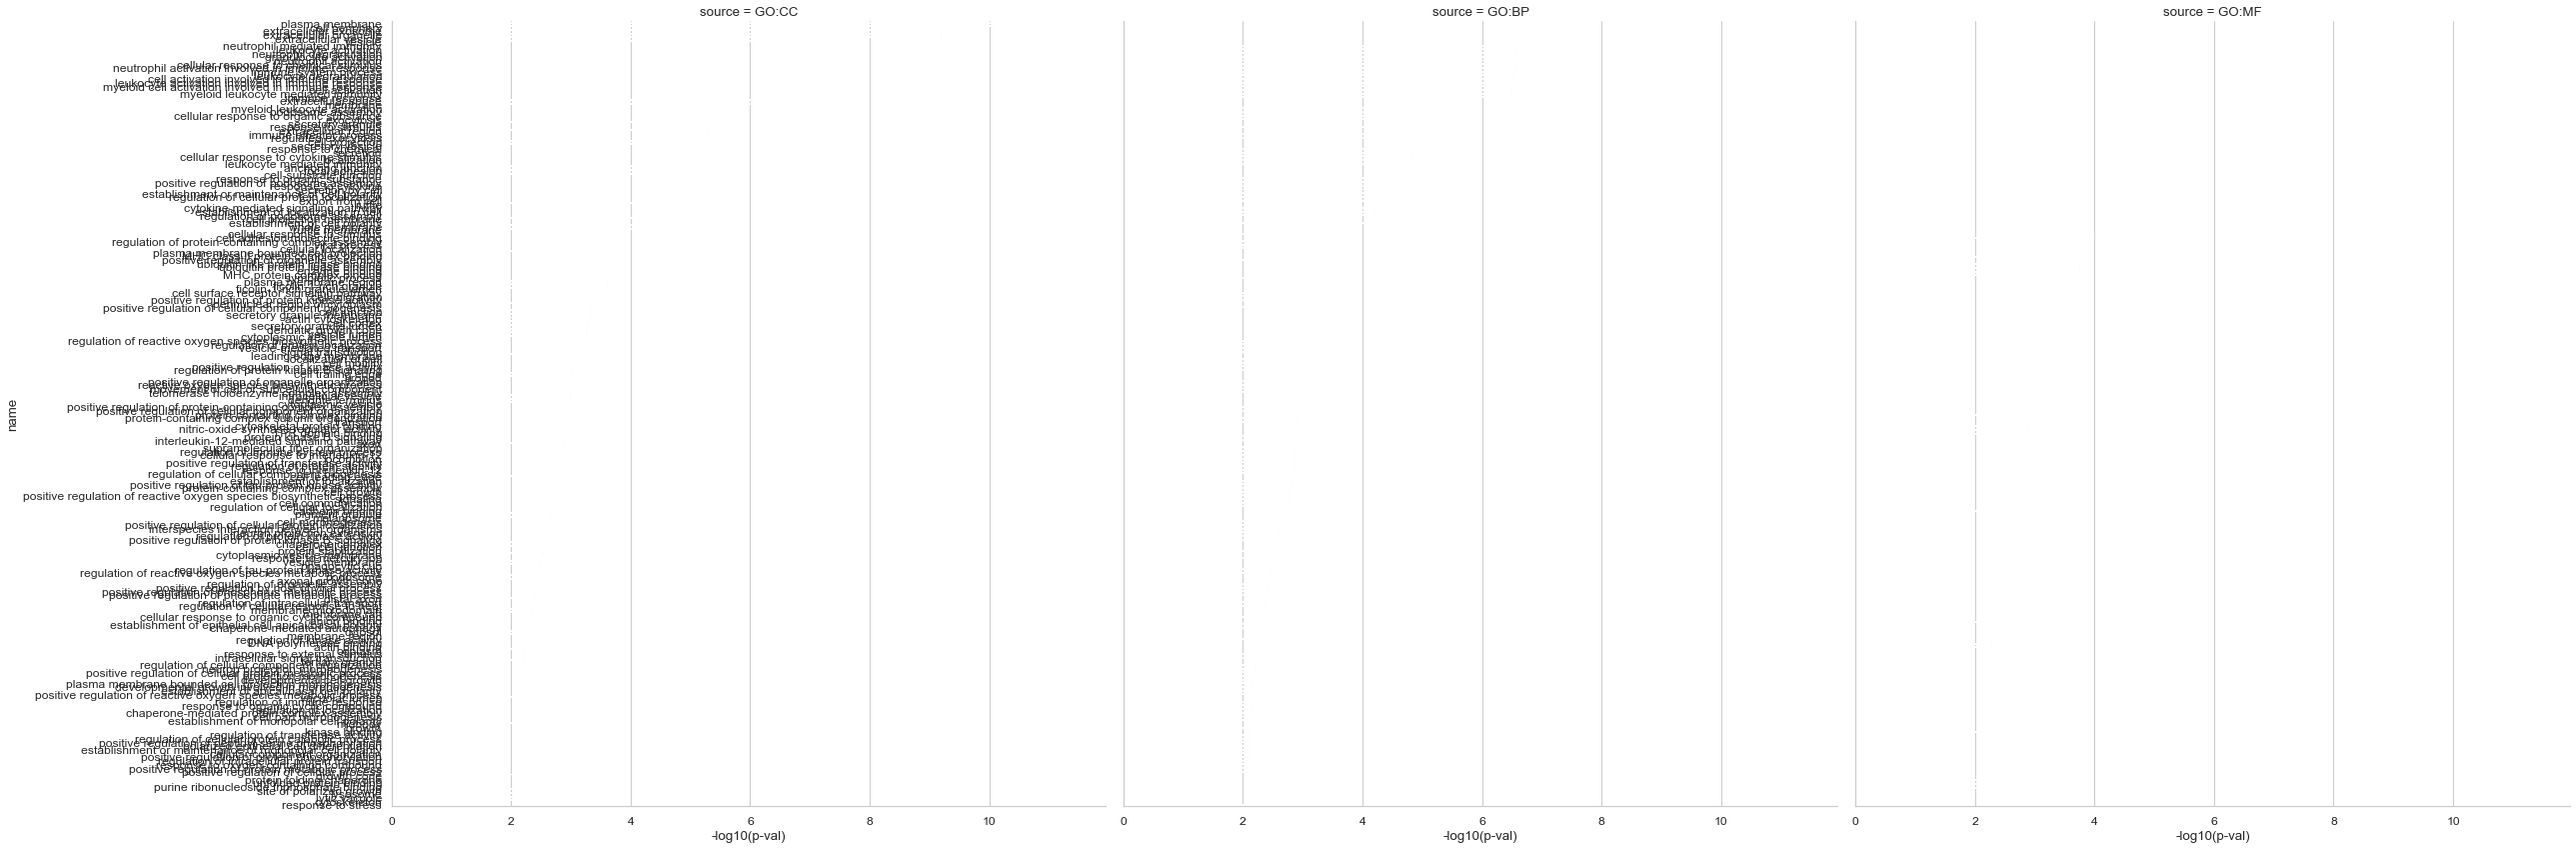

In [11]:
GOTermAnalysis(dataframe, difference="High")

# HSC-MPPs-Cycle: Liver vs Femur

In [12]:
group1 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/ShortGroup_HSC-MPPs-Cycle_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/Subsampled_HSC-MPPs-Cycle_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

reduced = adata[adata.obs.index.isin(group1+group2)]

np.unique(reduced.obs["Cluster"])

array(['HSC-MPPs-Cycle'], dtype=object)

## Subsampling biggest cluster, genes in at least 30% of cells (both groups)

Trying to set attribute `.uns` of view, copying.


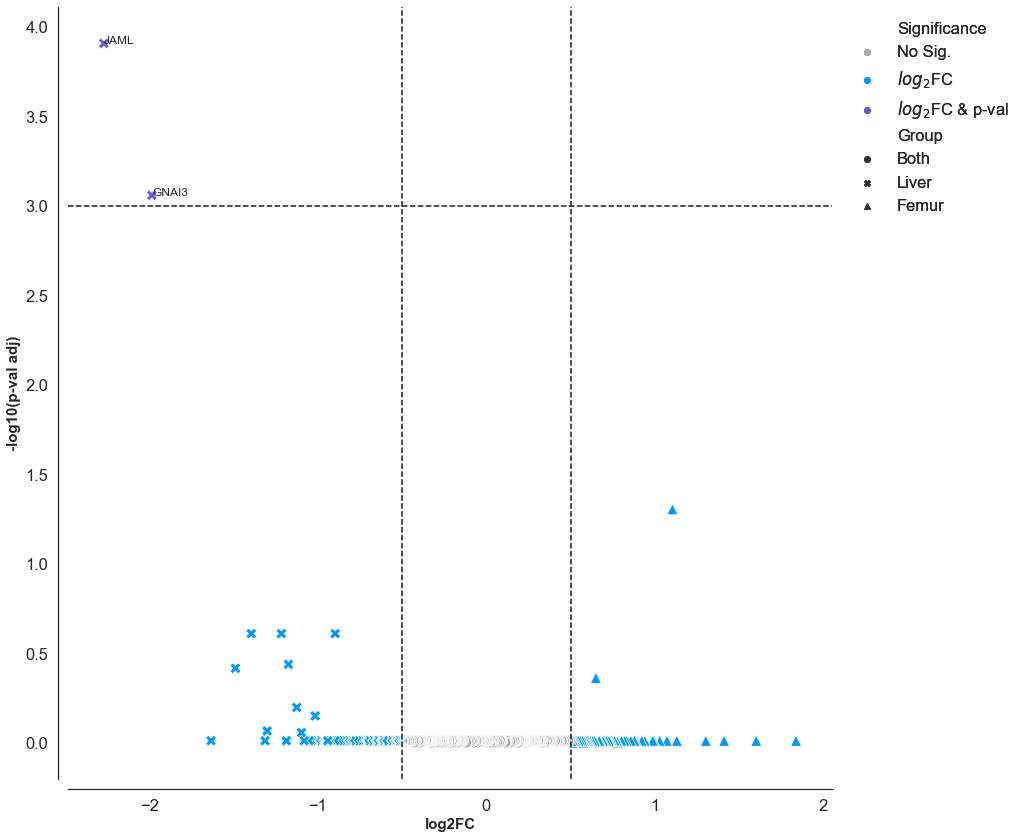

In [13]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "both",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [14]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


log2fc  -log10(p-val adj) difference  group  % cells group 1  \
GNAI3 -1.984351           3.059374       High  Liver        86.885246   
JAML  -2.269570           3.907882       High  Liver        32.786885   

       % cells group 2  
GNAI3        68.852459  
JAML         42.622951

## Subsampling biggest cluster, genes in at least 30% of cells (either group1 or group2)

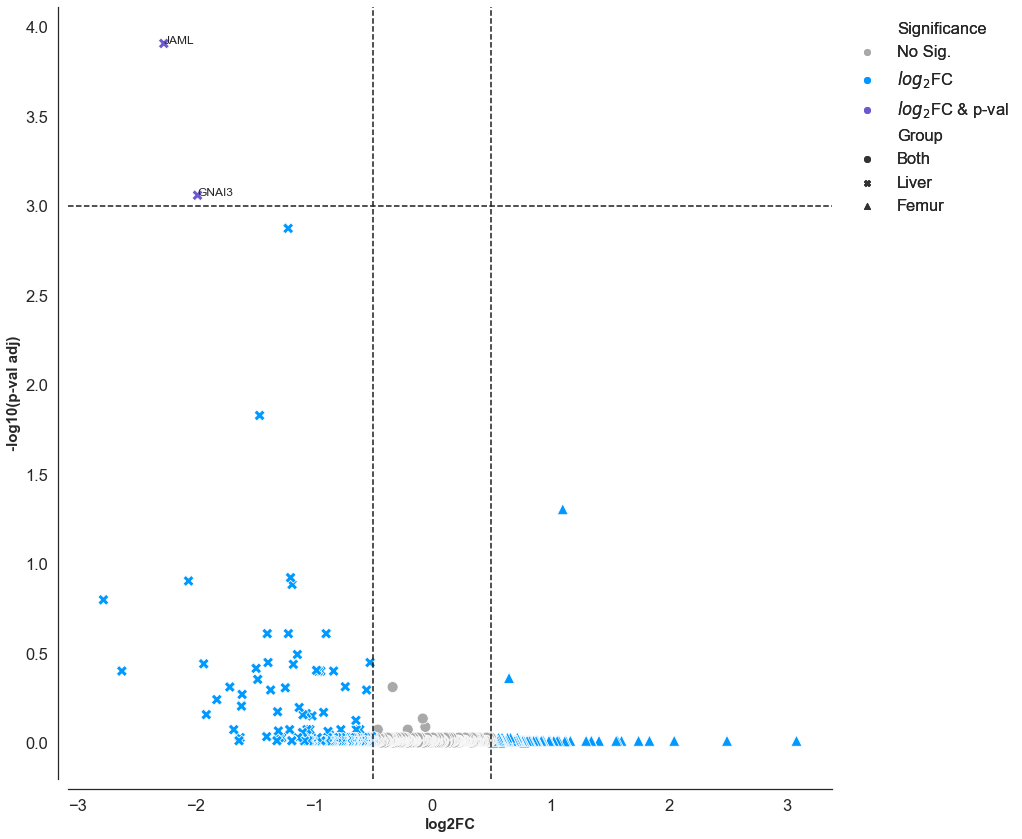

In [15]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [16]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


log2fc  -log10(p-val adj) difference  group  % cells group 1  \
GNAI3 -1.984351           3.059374       High  Liver        31.147541   
JAML  -2.269570           3.907882       High  Liver        75.409836   

       % cells group 2  
GNAI3        24.590164  
JAML         65.573770

# MEMPs: Liver vs Femur

In [17]:
group1 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/ShortGroup_MEMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/Subsampled_MEMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

reduced = adata[adata.obs.index.isin(group1+group2)]

np.unique(reduced.obs["Cluster"])

array(['MEMPs'], dtype=object)

## Subsampling biggest cluster, genes in at least 30% of cells (both groups)

Trying to set attribute `.uns` of view, copying.


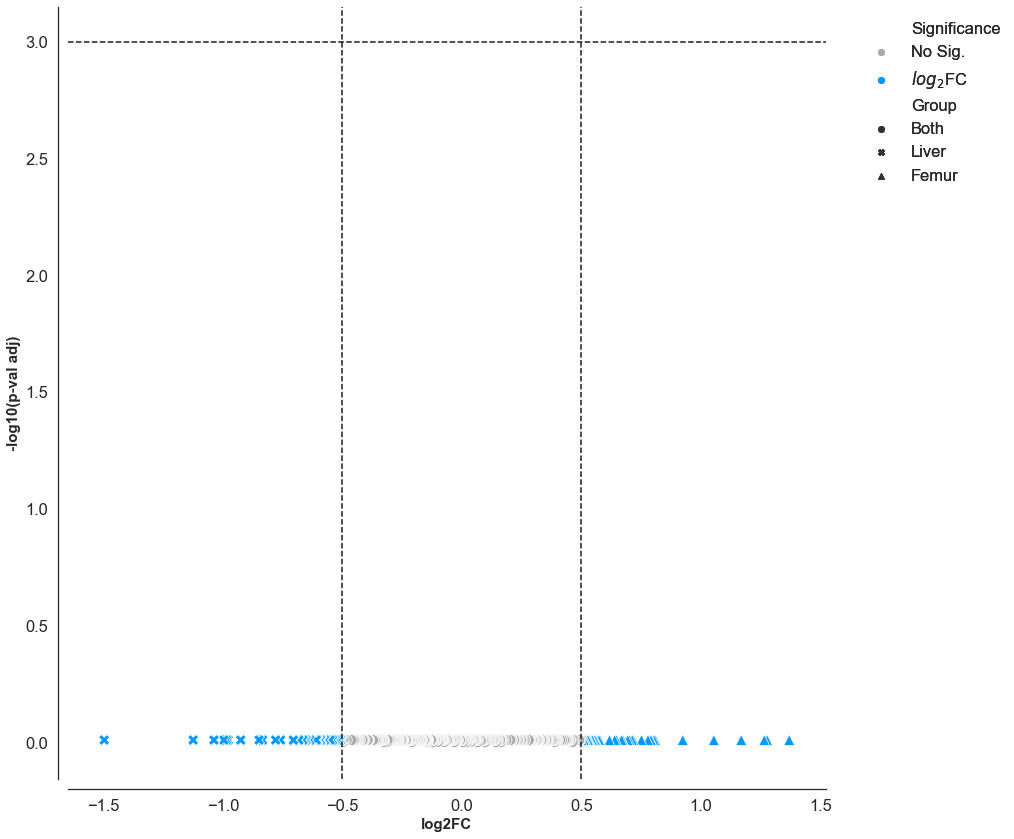

In [18]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "both",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [19]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []

## Subsampling biggest cluster, genes in at least 30% of cells (either group1 or group2)

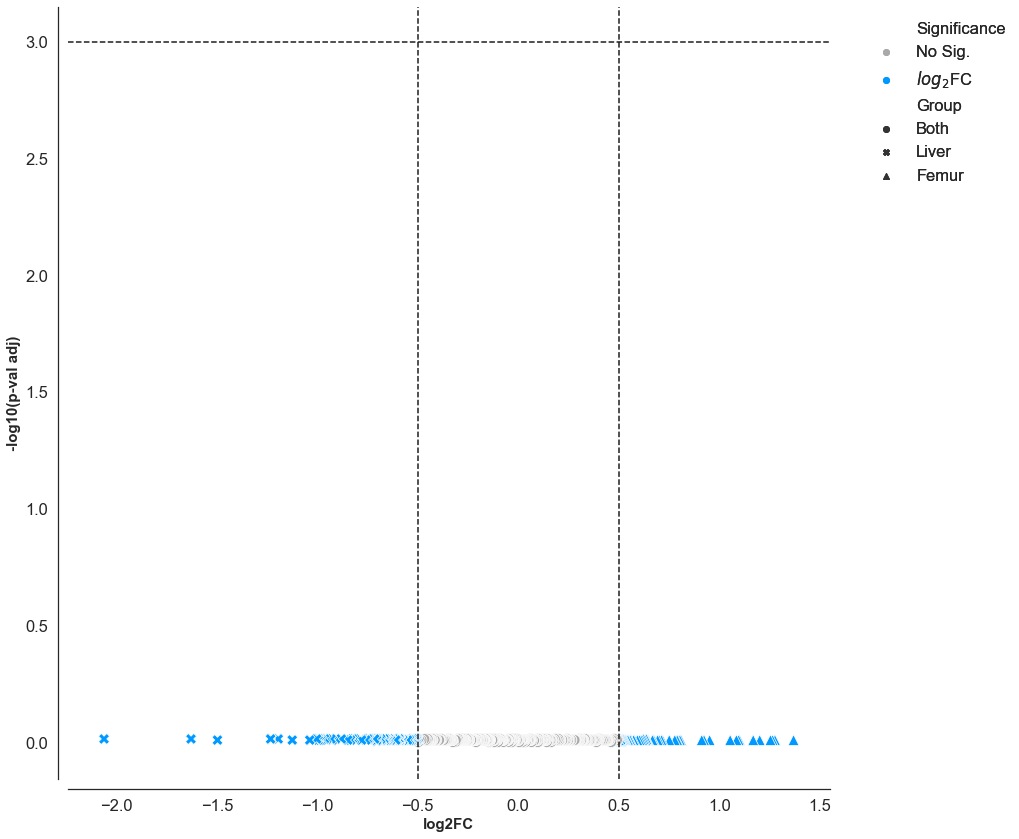

In [20]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [21]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []

# MEMPs-Cycle: Liver vs Femur

In [22]:
group1 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/ShortGroup_MEMPs-Cycle_Femur_vs_Liver.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/Subsampled_MEMPs-Cycle_Femur_vs_Liver.csv",
                     header=None, sep=",")[0].tolist()

reduced = adata[adata.obs.index.isin(group1+group2)]

np.unique(reduced.obs["Cluster"])

array(['MEMPs-Cycle'], dtype=object)

## Subsampling biggest cluster, genes in at least 30% of cells (both groups)

Trying to set attribute `.uns` of view, copying.


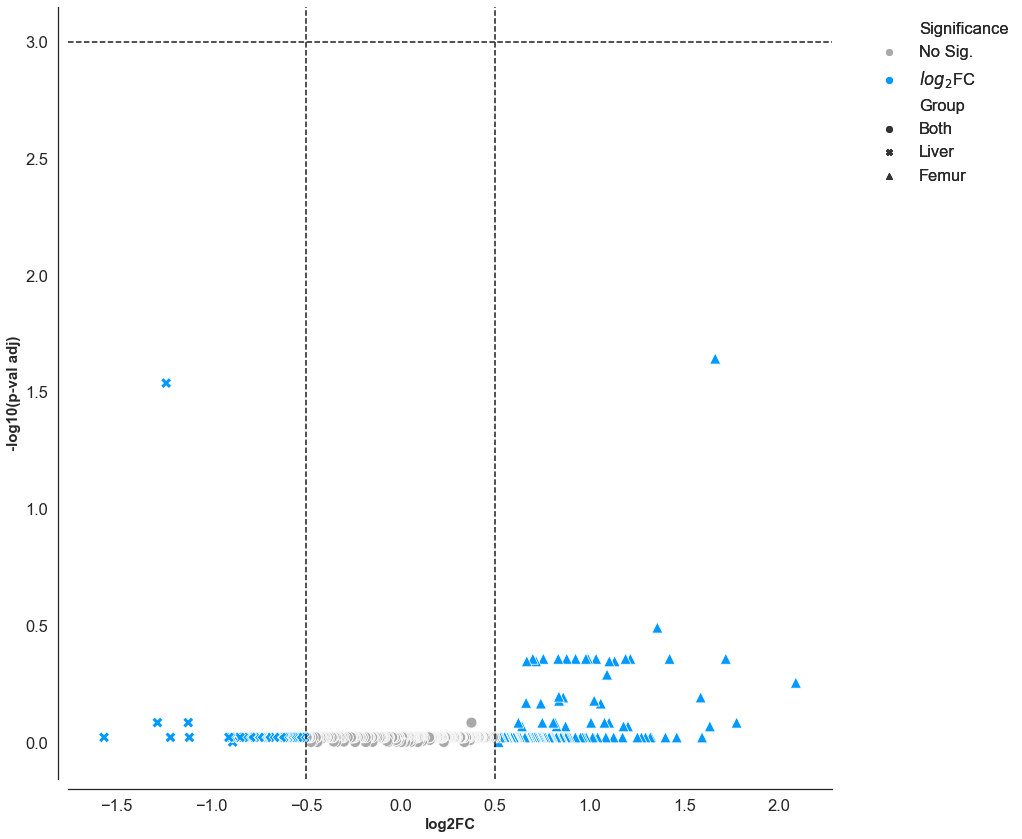

In [23]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "both",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [24]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []

## Subsampling biggest cluster, genes in at least 30% of cells (either group1 or group2)

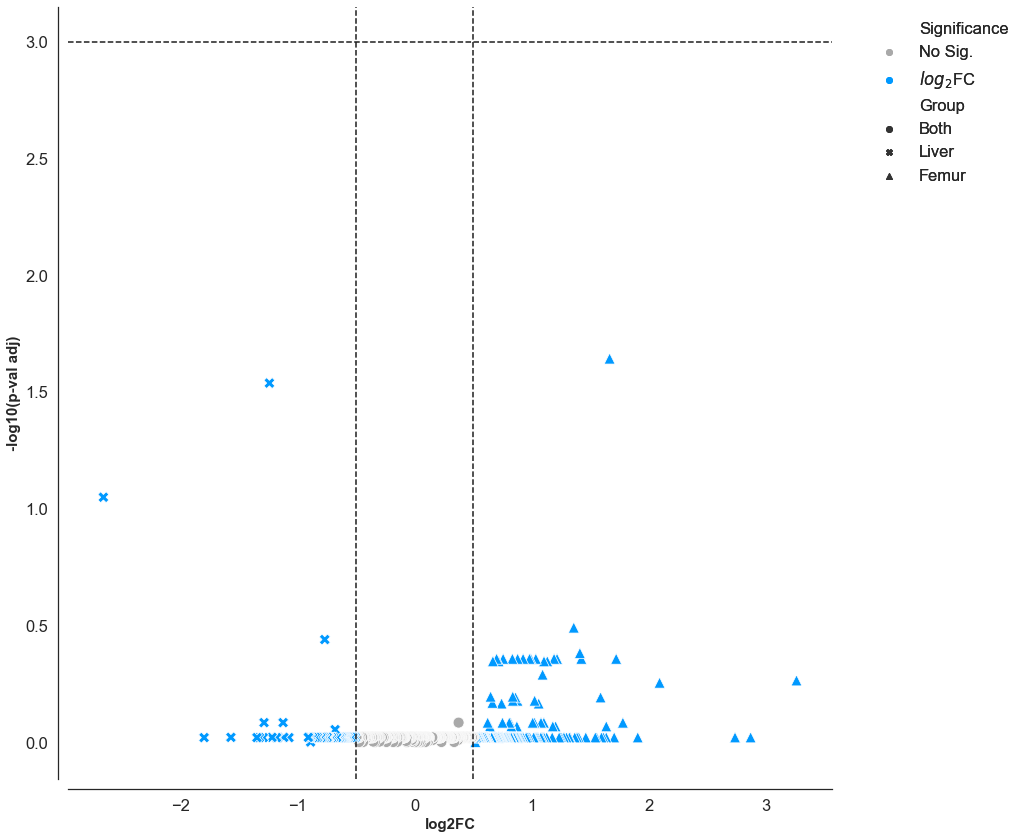

In [25]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [26]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []

# LMPs: Liver vs Femur

In [27]:
group1 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/ShortGroup_LMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/Subsampled_LMPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

reduced = adata[adata.obs.index.isin(group1+group2)]

np.unique(reduced.obs["Cluster"])

array(['LMPs'], dtype=object)

## Subsampling biggest cluster, genes in at least 30% of cells (both groups)

Trying to set attribute `.uns` of view, copying.


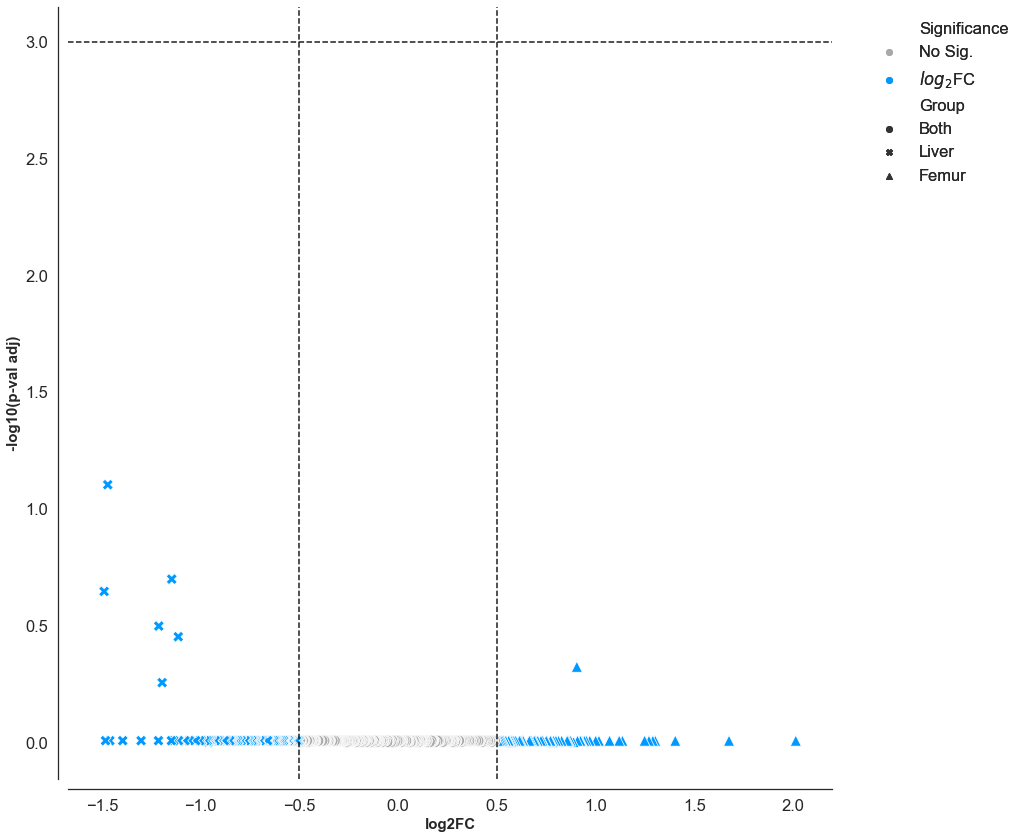

In [28]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "both",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [29]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []

## Subsampling biggest cluster, genes in at least 30% of cells (either group1 or group2)

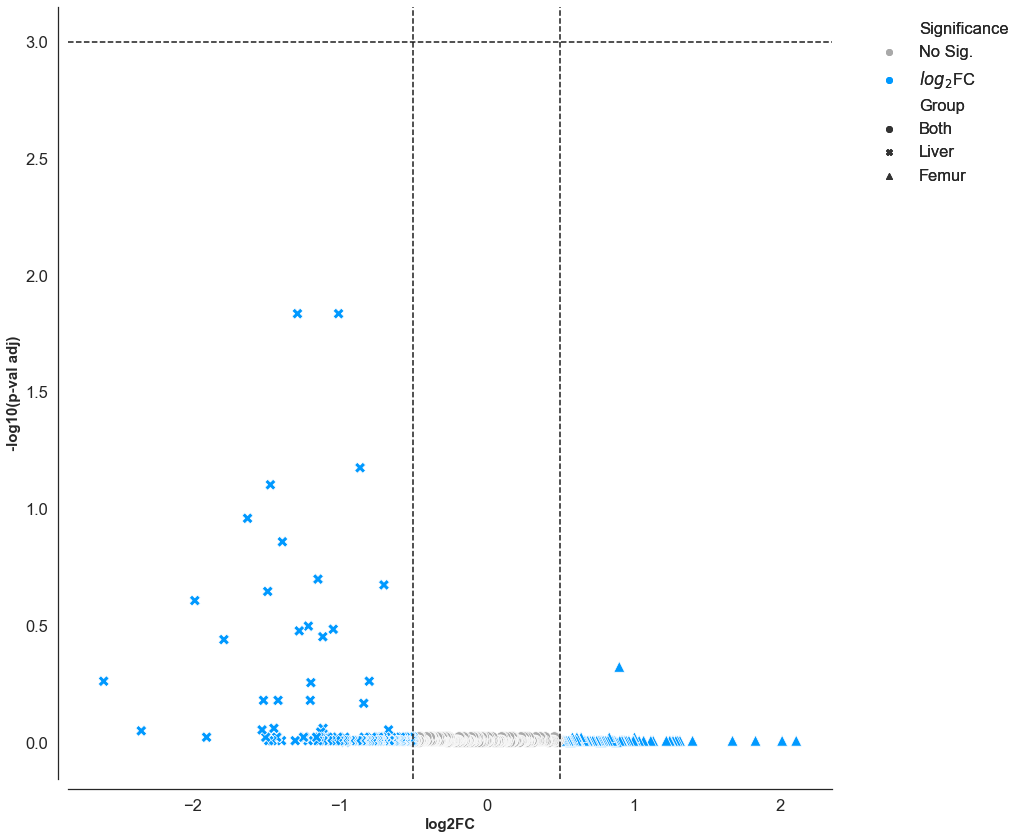

In [30]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [31]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []

# GPs: Liver vs Femur

In [32]:
group1 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/ShortGroup_GPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()
group2 = pd.read_csv("../MetaData/Resources/SubsamplingMembrane/Subsampled_GPs_Liver_vs_Femur.csv",
                     header=None, sep=",")[0].tolist()

reduced = adata[adata.obs.index.isin(group1+group2)]

np.unique(reduced.obs["Cluster"])

array(['GPs'], dtype=object)

## Subsampling biggest cluster, genes in at least 30% of cells (both groups)

Trying to set attribute `.uns` of view, copying.


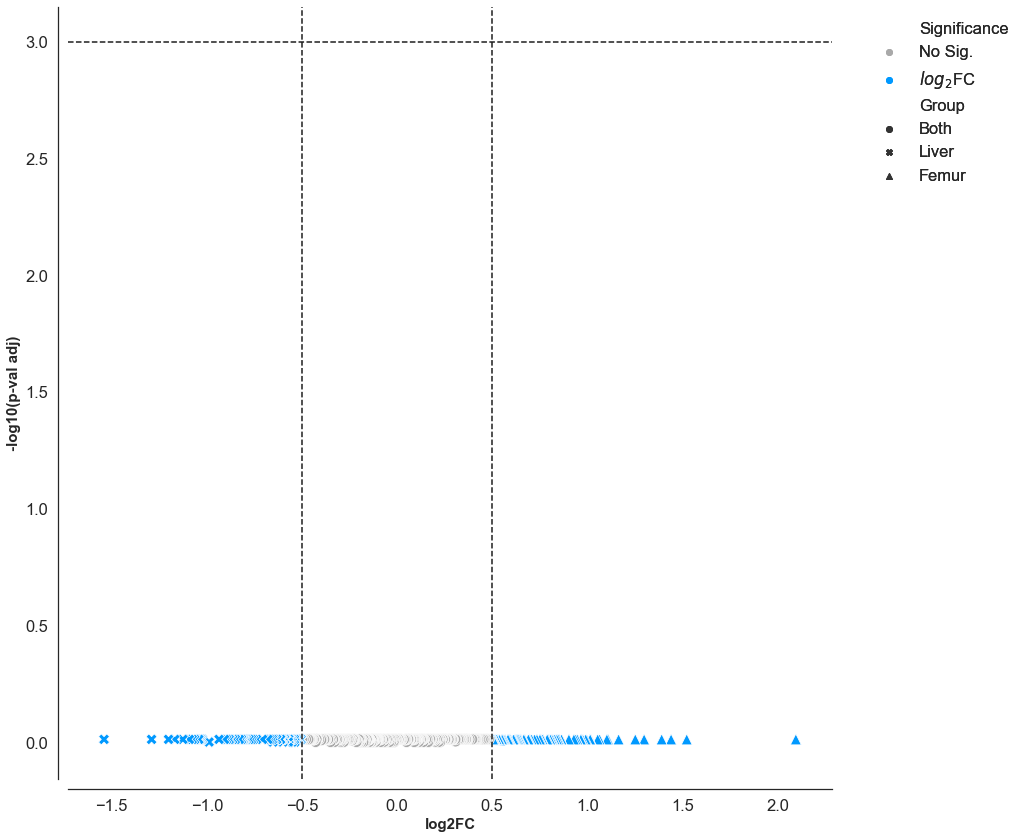

In [33]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "both",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [34]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []

## Subsampling biggest cluster, genes in at least 30% of cells (either group1 or group2)

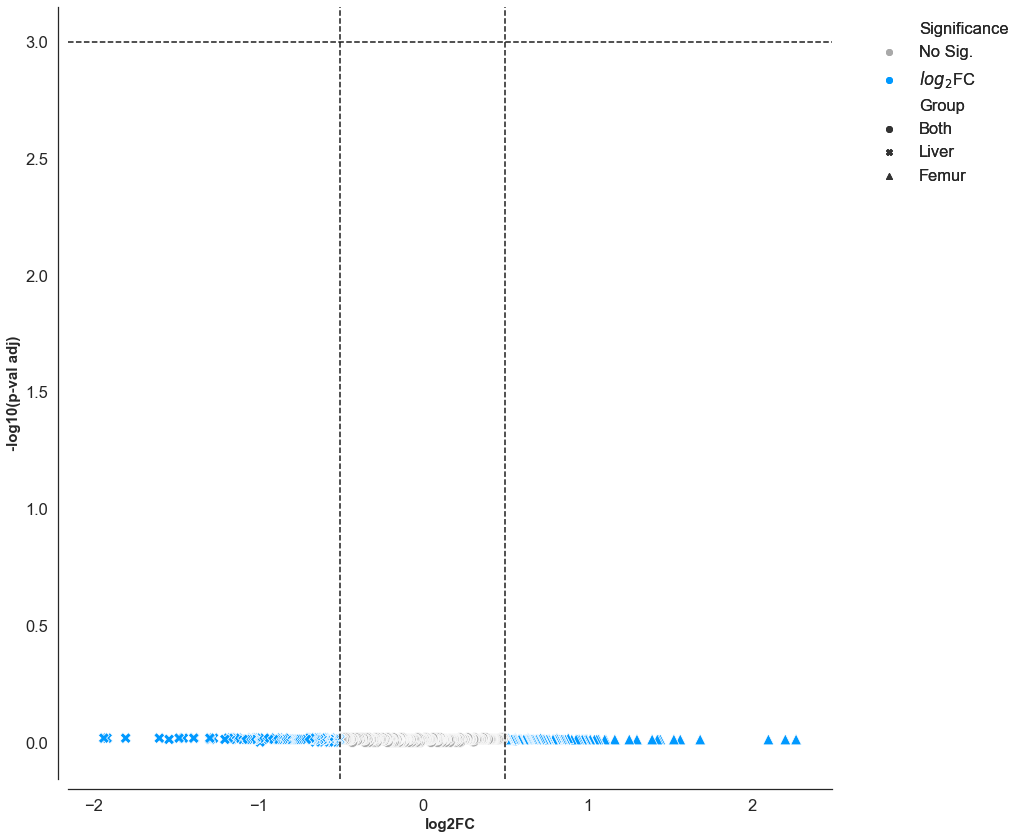

In [35]:
dataframe, fig = runDE_analysis(reduced,
                                group_by = "origin",
                                group1   = "Liver",
                                group2   = "Femur",
                                use_raw  = True,
                                log      = True,
                                min_pct  = 0.3,
                                max_pct  = 1.0,
                                min_fc   = 0.0,
                                where    = "either",
                                logfc_th = 0.5,
                                pval_th  = 1e-3,
                                figsize  = (12,12),
                                topGenes = -1)

In [36]:
GOTermAnalysis(dataframe, difference="High")

* GO term analysis on group Femur
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []




* GO term analysis on group Liver
	Using only gene with High difference


Empty DataFrame
Columns: [log2fc, -log10(p-val adj), difference, group, % cells group 1, % cells group 2]
Index: []